<a href="https://colab.research.google.com/github/uofg-iom/CNN_development/blob/google-colab/cnn_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%ls
!cd .
! git status
! git pull

sample_data/
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [2]:
!git clone https://github.com/uofg-iom/CNN_development.git

Cloning into 'CNN_development'...
remote: Enumerating objects: 1717, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 1717 (delta 19), reused 103 (delta 13), pack-reused 1600
Receiving objects: 100% (1717/1717), 117.23 MiB | 37.48 MiB/s, done.
Resolving deltas: 100% (613/613), done.


In [3]:
%cd /content/CNN_development
!git status
!git checkout google-colab

/content/CNN_development
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Branch 'google-colab' set up to track remote branch 'google-colab' from 'origin'.
Switched to a new branch 'google-colab'


# Introductory work on CNN development

Sources:
* Main guide: https://keras.io/getting_started/intro_to_keras_for_engineers/
* Augmentation layers: https://keras.io/api/layers/preprocessing_layers/image_augmentation/
* Image classification example: https://keras.io/examples/vision/image_classification_from_scratch/



In [5]:
import numpy as np
import tensorflow as tf
# from tensorflow import keras
from matplotlib import pyplot as plt


# Data Augmentation layer can take place as a model layer (synchronous)
# or to the dataset (asynchronously) before being passed to the model
# The synchronous option benefits from GPU acceleration, however it will be slower when run on a CPU
# The asynchronous option is better if we are training on a CPU

SYNCHRONOUS_AUGM = True
dataset_path = "00 - Datasets split by class - Watermark Removed"

# Load dataset

In [6]:
# Load dataset as TensorFlow Dataset Object
# Shuffle argument shuffles all images in all classes and places them into batches
# If shuffle is false, then the data is placed into batches based on the order in which they are loaded 
# Image size downsizes the image to the specified resolution, it doesn't crop
# If crop_to_aspect_ratio is selected then the image is cropped
rescale_image_size = (300,300)
ds_batch_size = 16

train_ds, val_ds  = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="both",
    batch_size=ds_batch_size,
    image_size=rescale_image_size,
    crop_to_aspect_ratio=False,
    color_mode='rgb',
    shuffle=True,
    seed=100)

class_names = train_ds.class_names
print(class_names)

# For demonstration, iterate over the batches yielded by the dataset.
# for data, labels in train_ds:
#    print(data.shape)  # (64, 200, 200, 3)
#    print(data.dtype)  # float32
#    print(labels.shape)  # (64,)
#    print(labels.dtype)  # int32


 
sel_batch = 6
num_rows = 3
num_cols = 3
            
# plt.figure(figsize=(10, 10))
# # .take() selects the batch number to show
# for images, labels in train_ds.take(sel_batch):
#     for i in range(num_rows*num_cols):
#         ax = plt.subplot(num_rows, num_cols, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.tight_layout()
#         # plt.axis("off")

Found 1562 files belonging to 5 classes.
Using 1250 files for training.
Using 312 files for validation.
['01 - Acne', '02 - Wrinkles', '03 - Dry skin', '04 - Normal skin', '05 - Oily skin']


# Create artificial images to increase dataset size

Apply image transformations (flip, rotate)

# Image Preprocessing

Keras comes with preprocessing layers to aid with resizing, cropping, normalization etc.

Good to use those so that model accepts raw data (RGB [0,255]) and performs all the preprocessing directly without external API dependencies.

Pre-processing can take place before training or during training.

In [7]:
# "Filters" to be applied sequentially to each image
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        # tf.keras.layers.RandomCrop(200, 200),
        tf.keras.layers.RandomBrightness(0.1),
        tf.keras.layers.RandomContrast(0.2), # Computationally expensive
        # tf.keras.layers.RandomZoom(0.2, 0.2) # Computationally expensive
        # tf.keras.layers.RandomTranslation(height_factor= 0.2, width_factor= 0.2, fill_mode="nearest") # Perhaps too much for this application
    ]
)


In [ ]:
# Visualize the output from the applied filters
num_pics = 6
sel_branch = 6
num_rows = 3
num_cols = 3
for k in range(num_pics):
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(sel_branch):
        for i in range(num_rows*num_cols):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(augmented_images[k].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.tight_layout()

## Pretrained models in Literature
In the literature we have seen the following models used:
* 2x (Conv + MaxPooling) layers in https://ieeexplore.ieee.org/document/9580174
* ResNet 152 model in https://arxiv.org/ftp/arxiv/papers/1907/1907.07901.pdf
* AlexNet (5x Conv with some MaxPooling layers in between some layers) in https://www.sciencedirect.com/science/article/pii/S1877050919321295?via%3Dihub
* GoogleNet (22 layers deep) (trained on ImageNet dataset) using transfer-learning process in https://link.springer.com/chapter/10.1007/978-981-15-2188-1_14
* Custom model (2x (Conv + MaxPooling)) with final Dense layer of shape 7 due to 7 classes in https://www.nature.com/articles/s41598-018-24204-6
* Also used VGG16 model in https://www.nature.com/articles/s41598-018-24204-6
* GoogleNet in https://link-springer-com.ezproxy.lib.gla.ac.uk/chapter/10.1007/978-3-319-59876-5_53
* ResNet50 and ResNet 152 in https://www.frontiersin.org/articles/10.3389/fmed.2021.644327/full
* MobileNet has been used in Dragomir https://ieeexplore.ieee.org/document/9301064

## Pretrained models available in Keras
https://keras.io/api/applications/


# Creating custom model with Keras layers

Guide for adding preprocessing layers to `keras.application`, i.e. pre-defined model:
https://www.tensorflow.org/guide/keras/preprocessing_layers


In [8]:
# Data Augmentation layer can take place as a model layer (synchronous)
# or to the dataset (asynchronously) before being passed to the model
# The synchronous option benefits from GPU acceleration, however it will be slower when run on a CPU
# The asynchronous option is better if we are training on a CPU
from enum import Enum

class ModelType(Enum):
    CustomModel = 0
    MobileNet = 1
    ResNet50 = 2
    ResNet152 = 3
    VGG16 = 4
    Xception = 5


def build_model(image_size, num_classes, model_type):
    
    in_w = image_size[0]
    in_h = image_size[1]
    
    # When input data size is variable
    inputs = tf.keras.Input(shape=(in_w, in_h, 3))
    # x = tf.keras.layers.CenterCrop(height=200, width=200)(inputs)
    # If synchronous, add data augmentation layer as part of the model
    if(SYNCHRONOUS_AUGM):
        x = data_augmentation(inputs)
        # Scaling Layer (scales data into 0.0 - 1.0 range)
        x = tf.keras.layers.Rescaling(scale=1.0 / 255)(x)
    else:
        # Scaling Layer (scales data into 0.0 - 1.0 range)
        x = tf.keras.layers.Rescaling(scale=1.0 / 255)(inputs)
    
    if model_type == ModelType.CustomModel:
        
        
        # ----------- Add Model Layers here ---------------
        # Here layers are added randomly as example. See main guide.
            
        # Apply some convolution and pooling layers
        x = tf.keras.layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)
        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(x)
        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        # Apply global average pooling to get flat feature vectors
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        # -------------------------------------------------
        
        
        # Dropout layer helps prevent overfitting by setting one input to 0 randomly
        # arguement is float from 0-1, fraction of the input units to drop.
        x = tf.keras.layers.Dropout(0.1)(x)
        outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    
    elif model_type == ModelType.ResNet152:
        # Following preprocess_input() method is required by ResNet
        # See https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/ResNet152V2
        
        x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
        x = tf.keras.layers.Dropout(0.1)(x)
        outputs = tf.keras.applications.ResNet152V2(
            include_top=True,
            weights=None,
            input_tensor=None,
            input_shape=(in_w, in_h, 3),
            pooling="avg",
            classes=num_classes,
            classifier_activation="softmax")(x)
        
    
    return tf.keras.Model(inputs, outputs)
    

model = build_model(rescale_image_size, len(class_names), ModelType.ResNet152)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 dropout (Dropout)           (None, 300, 300, 3)       0         
                                                                 
 resnet152v2 (Functional)    (None, 5)                 58341893  
                                                                 
Total params: 58,341,893
Trainable params: 58,198,149
Non-tra

## Callbacks to have checkpoints of model during training

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Adding callbacks to store the model while it is being trained.
# Models is saved at the start and end of each batch and epoch
model_path = "./model/"

checkpoint_path = model_path + 'model_chp'
google_drive_path = "/content/drive/MyDrive/Colab Notebooks/trained_model/model_chp"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath= google_drive_path,
        save_freq='epoch',
        save_weights_only=True,
        save_best_only = True)
]

# Train Model
* Training done with `fit()` method.
* Before calling `fit()`, need to set an **optimizer** and a **loss function** 

Good explanation and example
https://www.tensorflow.org/tutorials/images/classification

In [11]:
# If asynchronous, train the dataset before passing to the model
# If you're training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.
# See Image Classification example linked at the top of Notebook
if(not SYNCHRONOUS_AUGM):
    # Might need to use image data generate class so that the augmented images are kept
    augmented_train_ds = train_ds.map(
        lambda x, y: (data_augmentation(x, training=True), y),
        num_parallel_calls=tf.data.AUTOTUNE)
    
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# --------- Specify Optimizer and Loss function ---------
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

# Save the weights using the `checkpoint_path` format
model.save_weights(google_drive_path.format(epoch=0))


In [12]:
import os

print(os.listdir("/content/drive/MyDrive/Colab Notebooks/model_epoch_17/"))

model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/model_epoch_17/")

['saved_model.pb', 'keras_metadata.pb', 'fingerprint.pb', 'variables', 'assets']


In [25]:
# Re-evaluate the model
loss, acc = model.evaluate(val_ds)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

20/20 [==============================] - 5s 225ms/step - loss: 0.9424 - acc: 0.8301
Restored model, accuracy: 83.01%


In [26]:
model.save("/content/drive/MyDrive/Colab Notebooks/trained_model_final/trained_model_120_epoch")

In [24]:
# --------- Continue Training model if loaded -------------
epochs = 10
# steps_per_epoch = 2
history = model.fit(
    train_ds,
    epochs=epochs,
    # steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
79/79 [==============================] - 59s 729ms/step - loss: 0.0580 - acc: 0.9848 - val_loss: 0.8355 - val_acc: 0.8173
Epoch 2/10
79/79 [==============================] - 56s 706ms/step - loss: 0.1035 - acc: 0.9704 - val_loss: 0.8452 - val_acc: 0.8269
Epoch 3/10
79/79 [==============================] - 57s 717ms/step - loss: 0.0825 - acc: 0.9768 - val_loss: 0.8084 - val_acc: 0.7981
Epoch 4/10
79/79 [==============================] - 57s 713ms/step - loss: 0.0411 - acc: 0.9872 - val_loss: 0.8354 - val_acc: 0.8494
Epoch 5/10
79/79 [==============================] - 57s 715ms/step - loss: 0.0609 - acc: 0.9816 - val_loss: 0.9335 - val_acc: 0.7981
Epoch 6/10
79/79 [==============================] - 57s 715ms/step - loss: 0.0517 - acc: 0.9824 - val_loss: 1.0100 - val_acc: 0.7949
Epoch 7/10
79/79 [==============================] - 56s 701ms/step - loss: 0.0956 - acc: 0.9744 - val_loss: 1.0192 - val_acc: 0.7949
Epoch 8/10
79/79 [==============================] - 56s 707ms/step - 

# Visualisation of Performance

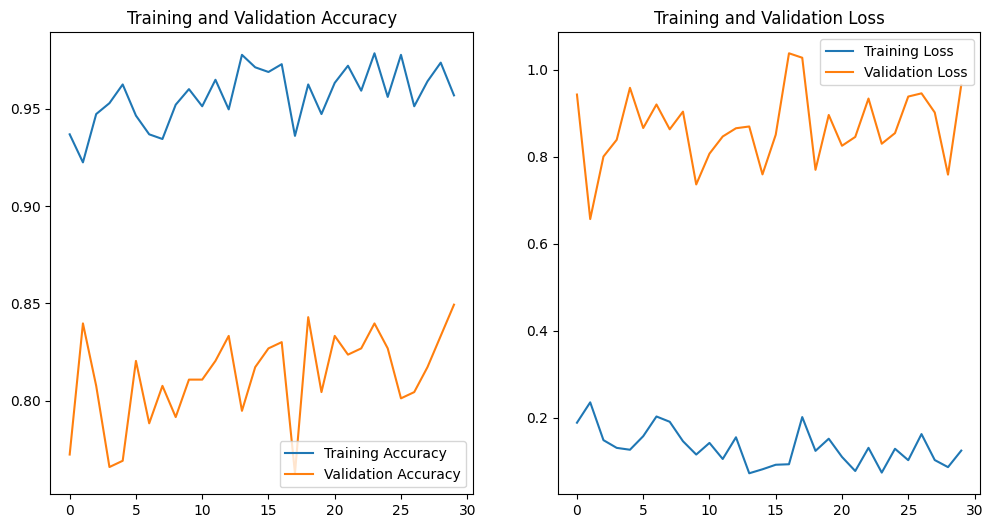

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Load pre-stored model and continue training

In [ ]:
# --------- Continue Training model -------------
epochs = 60
# steps_per_epoch = 2
history = model.fit(
    train_ds,
    epochs=epochs,
    # steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/60
79/79 [==============================] - 55s 690ms/step - loss: 0.7684 - acc: 0.7328 - val_loss: 1.3592 - val_acc: 0.6090
Epoch 2/60
79/79 [==============================] - ETA: 0s - loss: 0.7444 - acc: 0.7456

79/79 [==============================] - 150s 2s/step - loss: 0.7444 - acc: 0.7456 - val_loss: 0.6725 - val_acc: 0.7468
Epoch 3/60
79/79 [==============================] - 57s 722ms/step - loss: 0.7134 - acc: 0.7568 - val_loss: 0.7032 - val_acc: 0.7436
Epoch 4/60
79/79 [==============================] - 59s 746ms/step - loss: 0.7467 - acc: 0.7400 - val_loss: 1.2373 - val_acc: 0.5897
Epoch 5/60
79/79 [==============================] - ETA: 0s - loss: 0.7064 - acc: 0.7464

79/79 [==============================] - 150s 2s/step - loss: 0.7064 - acc: 0.7464 - val_loss: 0.6582 - val_acc: 0.7532
Epoch 6/60
79/79 [==============================] - 58s 730ms/step - loss: 0.6848 - acc: 0.7576 - val_loss: 0.8812 - val_acc: 0.7308
Epoch 7/60
79/79 [==============================] - 60s 756ms/step - loss: 0.6496 - acc: 0.7624 - val_loss: 0.7708 - val_acc: 0.6795
Epoch 8/60
79/79 [==============================] - 59s 747ms/step - loss: 0.6467 - acc: 0.7736 - val_loss: 0.7266 - val_acc: 0.7372
Epoch 9/60
79/79 [==============================] - 61s 768ms/step - loss: 0.6479 - acc: 0.7688 - val_loss: 1.1576 - val_acc: 0.7436
Epoch 10/60
79/79 [==============================] - 60s 754ms/step - loss: 0.6190 - acc: 0.7768 - val_loss: 0.7190 - val_acc: 0.6987
Epoch 11/60
79/79 [==============================] - 59s 741ms/step - loss: 0.6312 - acc: 0.7720 - val_loss: 0.7138 - val_acc: 0.7724
Epoch 12/60
79/79 [==============================] - 59s 746ms/step - loss: 0.61

79/79 [==============================] - 148s 2s/step - loss: 0.5990 - acc: 0.7888 - val_loss: 0.6240 - val_acc: 0.7372
Epoch 16/60
79/79 [==============================] - ETA: 0s - loss: 0.5838 - acc: 0.7920

79/79 [==============================] - 149s 2s/step - loss: 0.5838 - acc: 0.7920 - val_loss: 0.6106 - val_acc: 0.7821
Epoch 17/60
79/79 [==============================] - ETA: 0s - loss: 0.5839 - acc: 0.7944

79/79 [==============================] - 146s 2s/step - loss: 0.5839 - acc: 0.7944 - val_loss: 0.5890 - val_acc: 0.8013
Epoch 18/60
79/79 [==============================] - ETA: 0s - loss: 0.5731 - acc: 0.7936

79/79 [==============================] - 146s 2s/step - loss: 0.5731 - acc: 0.7936 - val_loss: 0.4982 - val_acc: 0.8109
Epoch 19/60
79/79 [==============================] - 57s 712ms/step - loss: 0.5537 - acc: 0.8072 - val_loss: 0.5776 - val_acc: 0.7885
Epoch 20/60
79/79 [==============================] - 59s 740ms/step - loss: 0.5239 - acc: 0.8040 - val_loss: 0.7303 - val_acc: 0.7821
Epoch 21/60
79/79 [==============================] - 60s 757ms/step - loss: 0.5579 - acc: 0.8040 - val_loss: 0.5990 - val_acc: 0.7724
Epoch 22/60
79/79 [==============================] - 60s 755ms/step - loss: 0.5184 - acc: 0.8064 - val_loss: 0.7227 - val_acc: 0.7308
Epoch 23/60
79/79 [==============================] - 60s 754ms/step - loss: 0.5017 - acc: 0.8200 - val_loss: 0.5701 - val_acc: 0.7885
Epoch 24/60
79/79 [==============================] - 59s 742ms/step - loss: 0.5025 - acc: 0.8088 - val_loss: 0.6718 - val_acc: 0.7372
Epoch 25/60
79/79 [==============================] - 60s 758ms/step - loss: 

In [ ]:
# !zip -r /content/CNN_development/todownload.zip /content/CNN_development/model/model_epoch_17

from google.colab import files
files.download("/content/CNN_development/todownload.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cd model

# Evaluate the model on validation data when training is done

In [18]:
loss, acc = model.evaluate(val_ds)  # returns loss and metrics
print("loss: %.2f" % loss)
print("acc: %.2f" % acc)

20/20 [==============================] - 5s 224ms/step - loss: 0.9646 - acc: 0.8494
loss: 0.96
acc: 0.85


# Run Inference on data

In [23]:
img = tf.keras.preprocessing.image.load_img(
    # "00 - Datasets split by class - Watermark Removed/01 - Acne/07RosaceaFulFAcepart_2.jpg", target_size=rescale_image_size
    # "/content/guy with acne.jpg", target_size=rescale_image_size
    "/content/me regular portrait.jpg", target_size=rescale_image_size

)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions[0])
score = predictions[0]
print(f"This image is\n {100 * score[0]:.2f}% Acne,\n {100 * score[1]:.2f}% Wrinkles, \
      \n {100 * score[2]:.2f}% Dry skin,\n {100 * score[3]:.2f}% Normal skin,\n {100 * score[4]:.2f}% Oily skin.")

1/1 [==============================] - 0s 41ms/step
[9.9949360e-01 3.4485055e-07 1.8971087e-04 1.4177788e-15 3.1630590e-04]
This image is
 99.95% Acne,
 0.00% Wrinkles,       
 0.02% Dry skin,
 0.00% Normal skin,
 0.03% Oily skin.


# Finding the best model configuration with hyperparameter tuning

In [ ]:
# Put model in a function
# Use hp argument (hyperparameter) in any parameter to tell Keras to tune it
def build_model(hp):
    inputs = tf.keras.Input(shape=(784,))
    x = tf.keras.layers.Dense(
        units=hp.Int('units', min_value=32, max_value=512, step=32),
        activation='relu')(inputs)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
import keras_tuner

tuner = keras_tuner.tuners.Hyperband(
  build_model,
  objective='val_loss',
  max_epochs=100,
  max_trials=200,
  executions_per_trial=2,
  directory='my_dir')

# MNIST model example

In [ ]:
# Get the data as Numpy arrays
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Build a simple model
inputs = tf.keras.Input(shape=(28, 28))
x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")